In [1]:
# install required system dependencies
!apt-get install -y xvfb x11-utils  
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.* \
            gym[box2d]==0.17.* 
!pip install pyglet
!pip install ffmpeg
! pip install pyvirtualdisplay
!pip install Image
!pip install gym-maze-trustycoder83

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 30 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,981 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 993 kB in 1s (1,334 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 160980 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:

In [2]:
!mkdir ./vid
!rm ./vid/*.*

rm: cannot remove './vid/*.*': No such file or directory


In [ ]:
import base64
import io
from IPython import display
def show_vid():
    video_name = "./vid/Test.mp4"

    video = io.open(video_name, 'r+b').read()
    encoded = base64.b64encode(video)

    display.display(display.HTML(data="""
      <video alt="test" controls>
      <source src="data:video/mp4;base64,{0}" type="video/mp4" />
      </video>
      """.format(encoded.decode('ascii'))))

In [3]:
import sys
import numpy as np
import gym
import gym_maze
from pyvirtualdisplay import Display
from gym.wrappers.monitoring import video_recorder

def simulate_environment(file_name, starting_value, n_episodes, max_iter_episode, exp_proba, discount_rate, exploration_decreasing_decay, min_exploration_proba, vid_enabled):
    
    d = Display()
    d.start()

    # Recording filename
    video_name = f"./vid/{file_name}.mp4"

    # Setup the environment for the maze
    env = gym.make("maze-sample-10x10-v0")

    # Setup the video
    

    # env = gym.wrappers.Monitor(env,'./vid',force=True)
    current_state = env.reset()

    states_dict = {}
    count = 0
    for i in range(10):
      for n in range(10):
        states_dict[i, n] = count
        count += 1
    
    n_actions = env.action_space.n

    #Define Q Table -> set starting q_value
    Q_table = np.zeros((len(states_dict), n_actions))
    Q_table[Q_table == 0] = starting_value

    Q_count_table = np.zeros((len(states_dict), n_actions))

    #Exploration Probability
    exploration_proba = exp_proba

    ####Learning Rate Fix
    rewards_per_episode = []
    for ep in range(n_episodes):
        vid = None
        vid = video_recorder.VideoRecorder(env,video_name)
        done = False

        total_ep_reward = 0

        for n in range(max_iter_episode):
            env.unwrapped.render()
            if vid_enabled:
                vid.capture_frame()
            current_x = int(current_state[0])
            current_y = int(current_state[1])

            current_Q_table = states_dict[current_x, current_y]

            ###Define action
            if np.random.uniform(0, 1) < exploration_proba:
                action = env.action_space.sample()
            else:
                action = int(np.argmax(Q_table[current_Q_table]))
            
            next_state, reward, done, _ = env.step(action)

            total_ep_reward += reward

            #
            next_x = int(next_state[0])
            next_y = int(next_state[1])
            
            next_Q_table = states_dict[next_x, next_y]
            
            Q_count_table[current_Q_table, action] += 1
            action_count = Q_count_table[current_Q_table, action]
            a = 1/action_count
            #Q_table[current_Q_table, action] = (1-lr) *Q_table[current_Q_table, action] + lr*(reward + max(Q_table[next_Q_table, :]))
            
            Q_table[current_Q_table, action] += a*((reward+max(Q_table[next_Q_table, :]))-discount_rate*Q_table[current_Q_table, action])

            if done:
                break
            
            current_state = next_state
        
        exploration_proba -= exploration_decreasing_decay
        if exploration_proba < min_exploration_proba:
            exploration_proba = min_exploration_proba
        
        print(f'Total Episode Reward: {total_ep_reward}')

        current_state = env.reset()

        rewards_per_episode.append(total_ep_reward)
    if vid_enabled:
        print("Video successfuly saved.")
        vid.close()
        vid.enabled = False
        show_vid()
    return rewards_per_episode



In [ ]:
import gc
discounts = [0.25, 0.5, 0.75, 1]
discount_dict = {}
for discount in discounts:
    discount_dict[discount] = simulate_environment(file_name='Test', starting_value=0, n_episodes=200, max_iter_episode=500, exp_proba=0, discount_rate=discount, exploration_decreasing_decay=0.01, min_exploration_proba=0, vid_enabled = False)
    gc.collect()

Total Episode Reward: 0.6899999999999997
Total Episode Reward: 0.8539999999999999
Total Episode Reward: -0.5000000000000003
Total Episode Reward: 0.8309999999999998
Total Episode Reward: 0.8439999999999999
Total Episode Reward: 0.8509999999999999
Total Episode Reward: 0.8409999999999999
Total Episode Reward: 0.8699999999999999
Total Episode Reward: 0.8649999999999999
Total Episode Reward: 0.8489999999999999
Total Episode Reward: 0.8719999999999999
Total Episode Reward: 0.8299999999999998
Total Episode Reward: 0.8939999999999999
Total Episode Reward: 0.8579999999999999
Total Episode Reward: 0.8569999999999999
Total Episode Reward: 0.8829999999999999
Total Episode Reward: 0.8549999999999999
Total Episode Reward: 0.8789999999999999
Total Episode Reward: 0.8799999999999999
Total Episode Reward: 0.8649999999999999
Total Episode Reward: 0.8649999999999999
Total Episode Reward: 0.8789999999999999
Total Episode Reward: 0.8699999999999999
Total Episode Reward: 0.8869999999999999
Total Episode R

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


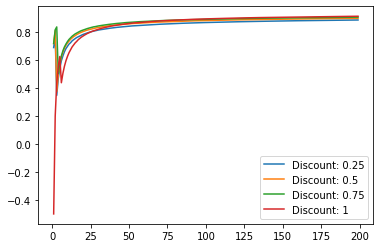

In [ ]:
import matplotlib.pyplot as plt

for key in discount_dict:
    line = []
    for i in range(len(discount_dict[key])):
        l = np.array(discount_dict[key][:i]).mean()
        line.append(l)

    plt.plot(line, label = f'Discount: {key}')

plt.legend()
plt.show()

In [4]:
import gc
epsilons = [0, 0.1, 0.25, 0.5]
epsilon_dict = {}
for epsilon in epsilons:
    epsilon_dict[epsilon] = simulate_environment(file_name='Test', starting_value=0, n_episodes=200, max_iter_episode=500, exp_proba=epsilon, discount_rate=1, exploration_decreasing_decay=0.0025, min_exploration_proba=0, vid_enabled = False)
    gc.collect()

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
Total Episode Reward: -0.5000000000000003
Total Episode Reward: 0.8999999999999999
Total Episode Reward: 0.9189999999999999
Total Episode Reward: 0.9129999999999999
Total Episode Reward: 0.8979999999999999
Total Episode Reward: -0.5000000000000003
Total Episode Reward: 0.9059999999999999
Total Episode Reward: 0.9109999999999999
Total Episode Reward: 0.9169999999999999
Total Episode Reward: 0.9099999999999999
Total Episode Reward: 0.9179999999999999
Total Episode Reward: 0.9079999999999999
Total Episode Reward: 0.9279999999999999
Total Episode Reward: 0.8999999999999999
Total Episode Reward: 0.9249999999999999
Total Episode Reward: 0.8959999999999999
Total Episode Reward: 0.942
Total Episode Reward: 0.9069999999999999
Total Episode Reward: 0.9249999999999999
Total Episode Reward: 0.9129999999999999
Total Episode Reward: 0.9159999999999999
Total Episode Reward: 0.9179999999999999
Total Episode Reward: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  rcount = _count_reduce_items(arr, axis)


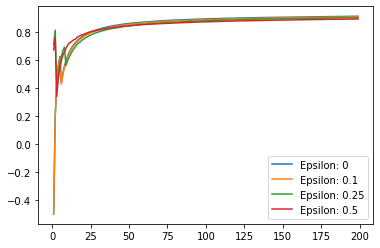

In [5]:
import matplotlib.pyplot as plt

for key in epsilon_dict:
    line = []
    for i in range(len(epsilon_dict[key])):
        l = np.array(epsilon_dict[key][:i]).mean()
        line.append(l)

    plt.plot(line, label = f'Epsilon: {key}')

plt.legend()
plt.show()

In [ ]:
comp_dict = {}
comp_dict['Realistic'] = simulate_environment(file_name='Test', starting_value=0, n_episodes=200, max_iter_episode=500, exp_proba=0.1, discount_rate=1, exploration_decreasing_decay=0.001, min_exploration_proba=0, vid_enabled = False)
comp_dict['Optimistic'] = simulate_environment(file_name='Test', starting_value=1, n_episodes=200, max_iter_episode=500, exp_proba=0, discount_rate=1, exploration_decreasing_decay=0.05, min_exploration_proba=0, vid_enabled = False)


Total Episode Reward: -0.5000000000000003
Total Episode Reward: 0.8989999999999999
Total Episode Reward: 0.9269999999999999
Total Episode Reward: 0.9039999999999999
Total Episode Reward: -0.5000000000000003
Total Episode Reward: 0.8959999999999999
Total Episode Reward: 0.9049999999999999
Total Episode Reward: 0.9069999999999999
Total Episode Reward: 0.8989999999999999
Total Episode Reward: 0.9039999999999999
Total Episode Reward: 0.9149999999999999
Total Episode Reward: 0.9119999999999999
Total Episode Reward: 0.9269999999999999
Total Episode Reward: 0.8799999999999999
Total Episode Reward: 0.9259999999999999
Total Episode Reward: 0.9159999999999999
Total Episode Reward: 0.9009999999999999
Total Episode Reward: 0.9189999999999999
Total Episode Reward: 0.8959999999999999
Total Episode Reward: 0.9319999999999999
Total Episode Reward: 0.9159999999999999
Total Episode Reward: 0.9149999999999999
Total Episode Reward: 0.9009999999999999
Total Episode Reward: 0.9119999999999999
Total Episode 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  rcount = _count_reduce_items(arr, axis)


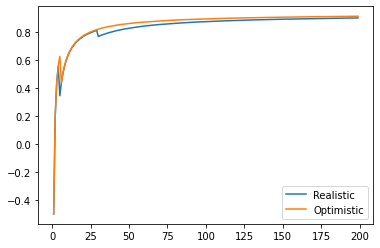

In [ ]:
import matplotlib.pyplot as plt
for key in comp_dict:
    line = []
    for i in range(len(comp_dict[key])):
        l = np.array(comp_dict[key][:i]).mean()
        line.append(l)

    plt.plot(line, label = f'{key}')

plt.legend()
plt.show()